# 🔹 Sabriya Sowers' Spotify Tracks Analysis 🔹

**Author:** Sabriya Sowers  
**Date:** October 27, 2025  
**Objective:** Determine which musical and genre features most influence Spotify track popularity and use them to predict future track performance.

In [1]:
# ruff: noqa: F401
# pyright: reportUnusedImport=false

#data manipulation and analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# statistical data visualization
import seaborn

# sample housing dataset for regression analysis
from sklearn.datasets import fetch_california_housing

# building a linear regression model
from sklearn.linear_model import LinearRegression

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for splitting data into training and test sets
from sklearn.model_selection import train_test_split

In [2]:
# Load your CSV
df = pd.read_csv("spotifydataset.csv")  # same folder as the notebook
df.head()
y = df["popularity"].dropna()

print(df.keys())
print()

df.drop(
    axis="columns",
    labels=[
        "record_id", "track_id", "artists", "album_name", "track_name",
        "duration_ms", "explicit", "key", "loudness", "mode",
        "speechiness", "instrumentalness", "liveness", "time_signature"
    ],
    inplace=True
)

df.dropna(axis="index", how="any", inplace=True)

df.head(n=10)
df.info()
df.tail(n=5)

Index(['record_id', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   popularity    114000 non-null  int64  
 1   danceability  114000 non-null  float64
 2   energy        114000 non-null  float64
 3   acousticness  114000 non-null  float64
 4   valence       114000 non-null  float64
 5   tempo         114000 non-null  float64
 6   track_genre   114000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 6.1+ MB


,popularity,danceability,energy,acousticness,valence,tempo,track_genre
113995,21,0.172,0.235,0.640,0.0339,125.995,world-music
113996,22,0.174,0.117,0.994,0.0350,85.239,world-music
113997,22,0.629,0.329,0.867,0.7430,132.378,world-music
113998,41,0.587,0.506,0.381,0.4130,135.960,world-music
113999,22,0.526,0.487,0.681,0.7080,79.198,world-music


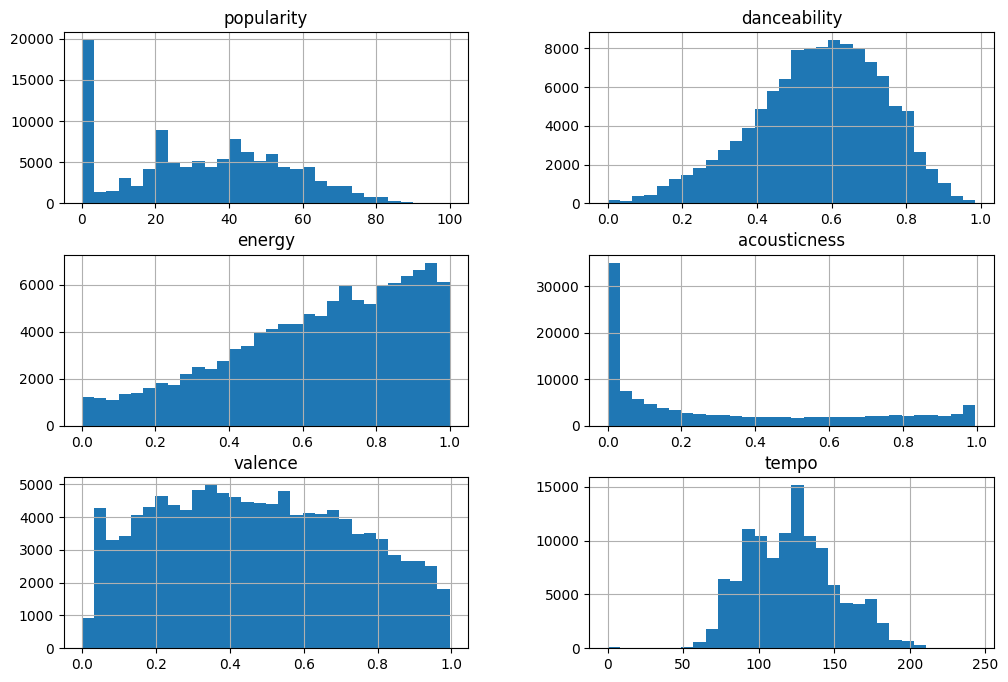

Text(0.5, 1.0, 'Distribution of Track Popularity')

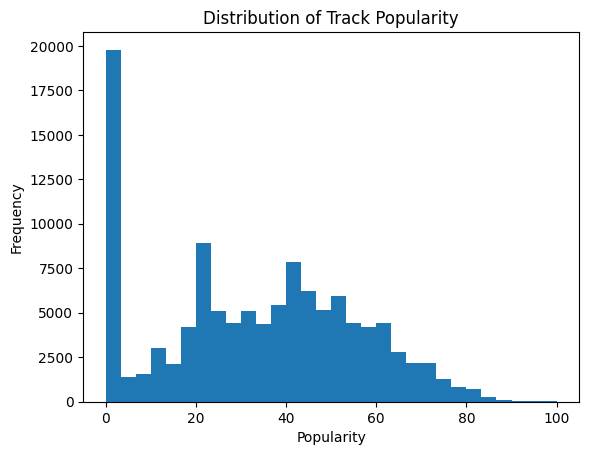

In [11]:
# Histogram with mean/median lines

# Calculates stats for your y target which is popularity
mean_val = y.mean()
median_val = y.median()
skew_val = y.skew()   # > 0 means right-skewed

# histogram for every numeric column in the entire DataFrame
df.hist(bins=30, figsize=(12, 8))

# Renders figure of many histograms
plt.show()

# single histogram specifically for popularity with labels
plt.hist(y, bins=30)
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.title("Distribution of Track Popularity")

The popularity distribution is right-skewed, meaning most tracks in the dataset have low popularity scores, while fewer tracks achieve high popularity. There is a large spike at the very low end (popularity close to 0), indicating many songs that are not widely streamed. The long tail stretching toward higher popularity shows that only a small number of tracks become big hits.